In [1]:
# =========================
# Libraries
# =========================

import numpy as np
import pandas as pd
from scipy.integrate import trapezoid
import emcee
from multiprocessing import pool
import multiprocessing as mp
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Loading BAO data (DESI_DR2)
# =========================

# Path
bao_dat_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/BAO/desi_gaussian_bao_ALL_GCcomb_mean.txt"
bao_cov_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/BAO/desi_gaussian_bao_ALL_GCcomb_cov.txt"

# DataFrame
df_bao = pd.read_csv(bao_dat_path, sep=r"\s+", comment="#", names=["z", "value", "quantity"])

# Main columns
z_bao = df_bao["z"].values
d_obs = df_bao["value"].values

# Covariance matrix and its inverse
cov_bao = np.loadtxt(bao_cov_path)
Cinv_bao = np.linalg.inv(cov_bao)

In [3]:
# =========================
# Fiducial
# =========================

# Uniform priors
H0_min, H0_max = 50., 90.
Om0_min, Om0_max = 0.1, 0.6
w_min, w_max = -3.0, 1.0

# Gaussian prior
mu_Ob, sigma_Ob = 0.0495, 0.0025

# Physical constant
c_kms = 299792.458

# Cosmological parameters
Or0 = 7.88e-5
Neff = 3.04

In [4]:
# =========================
# Hubble functions
# =========================

# Normalized Hubble parameter
def E_wCDM(z, Om0, w):

    # Matter density parameter
    Om = Om0 * (1 + z)**3

    # Radiation density parameter
    Or = Or0 * (1 + z)**4

    # Dark energy density parameter
    Ode0 = 1 - Om0 - Or0
    power = 3*(1 + w)
    Ode = Ode0 * (1 + z)**power

    return np.sqrt(Om + Or + Ode)


# Hubble parameter
def H_wCDM(z, H0, Om0, w):
    return H0 * E_wCDM(z, Om0, w)

In [5]:
# ==============================
# BAO functions
# ==============================

# Comoving distance
def comoving_dist(z, H0, Om0, w):

    # Redshift grid used for numerical integration
    z_samples = np.linspace(0, z, 1000)

    # Integrand of the comoving distance: 1 / E(z)
    y = 1.0 / E_wCDM(z_samples, Om0, w)

    # Numerical integration over redshift
    integral = trapezoid(y, z_samples)

    # Comoving distance in units of Mpc
    return (c_kms / H0) * integral


# Transverse BAO distance (scaled by rd)
def DM_over_rd(z, H0, Om0, Ob, w):

    # Dimensionless Hubble parameter squared: h ≡ H0 / 100 (km/s/Mpc)
    h2 = (H0 / 100)**2

    # Physical desities
    Obh2 = Ob * h2
    Omh2 = Om0 * h2

    # Sound horizon fitting formula
    rd = 147.05 * ((Obh2/0.02236 )**-0.13) * ((Omh2/0.1432)**-0.23) * ((Neff/3.04)**-0.1)

    # Comoving distance
    dC = comoving_dist(z, H0, Om0, w)
    return dC / rd 


# Hubble distance (scaled by rd)
def DH_over_rd(z, H0, Om0, Ob, w):

    # Same as in D_M/r_d
    h2 = (H0 / 100)**2
    Obh2 = Ob * h2
    Omh2 = Om0 * h2
    rd = 147.05 * ((Obh2/0.02236 )**-0.13) * ((Omh2/0.1432)**-0.23) * ((Neff/3.04)**-0.1)

    # Hubble parameter
    H_theo = H_wCDM(z, H0, Om0, w)

    # Hubble distance
    DH_theo = c_kms / H_theo
    return DH_theo / rd


# Volume-averaged distance (scaled by rd)
def DV_over_rd(z, H0, Om0, Ob, w):

    # Transverse BAO distance (scaled by rd)
    dm = DM_over_rd(z, H0, Om0, Ob, w)

    # Hubble distance (scaled by rd)
    dh = DH_over_rd(z, H0, Om0, Ob, w)

    return (z * dm**2 * dh)**(1/3)


# ==============================
# Theoretical BAO distance vector (following the d_obs sequence)
# ==============================

def d_wCDM(z, H0, Om0, Ob, w):

    # List to store the model predictions in the same order as the data
    d_model = []

    # Loop over BAO measurements
    for _, row in df_bao.iterrows():

        z = row["z"]             # Redshift of the BAO measurement
        q = row["quantity"]      # Type of BAO observable

        # Select the appropriate theoretical BAO distance
        if q == "DV_over_rs":
            d = DV_over_rd(z, H0, Om0, Ob, w)

        elif q == "DM_over_rs":
            d = DM_over_rd(z, H0, Om0, Ob, w)

        elif q == "DH_over_rs":
            d = DH_over_rd(z, H0, Om0, Ob, w)

        else:
            raise ValueError(f"Unknown BAO observable: {q}")  # Safety check for unsupported observables

        d_model.append(d)
        
    # Return model BAO vector as a NumPy array
    return np.array(d_model)


# ========================
# Sanity test
# ========================

print("d_wCDM(z_bao) =", d_wCDM(z_bao, 70, 0.3, 0.0495, -1.0))

d_wCDM(z_bao) = [ 7.91976415 13.28342599 22.49262762 17.44426444 20.00919635 21.71007652
 17.47577669 27.77430275 14.03234432 29.96414452 12.86138737  8.62496113
 38.87042262]


In [6]:
# =========================================
# BAO Likelihood (DESI_DR2)
# =========================================

# Log-priors
def lnprior_bao(theta_bao):
    
    # Params vector
    H0, Om0, Ob, w = theta_bao
    
    # Flat priors
    if not (H0_min < H0 < H0_max):     return -np.inf
    if not (Om0_min < Om0 < Om0_max):  return -np.inf
    if not (w_min <= w <= w_max):      return -np.inf

    # Gaussian prior on Omega_b
    lp_Ob = -0.5 * ((Ob - mu_Ob)**2 / sigma_Ob**2) - np.log(sigma_Ob * np.sqrt(2*np.pi))
    
    return lp_Ob


# Log-likelihood
def lnlike_bao(theta_bao, z_bao, d_obs, Cinv_bao):
    H0, Om0, Ob, w = theta_bao

    # Theoretical BAO distance vector
    d_model = d_wCDM(z_bao, H0, Om0, Ob, w)

    # Residual vector
    delta = d_obs - d_model

    # Chi-squared
    chi2_bao = np.dot(delta, np.dot(Cinv_bao, delta))

    return -0.5 * chi2_bao


# Log-posterior
def lnprob_bao(theta_bao, z_bao, d_obs, Cinv_bao):

    # Log-prior
    lp = lnprior_bao(theta_bao)
    if not np.isfinite(lp):
        return -np.inf
    
    # Log-likelihood
    ll = lnlike_bao(theta_bao, z_bao, d_obs, Cinv_bao)

    return lp + ll


# =========================
# Quick test
# =========================

theta_bao_test = [70, 0.3, 0.0495, -1.0]
print("wCDM_BAO log-posterior =", lnprob_bao(theta_bao_test, z_bao, d_obs, Cinv_bao))

wCDM_BAO log-posterior = -0.16847254446595183


In [7]:
# =========================
# MCMC configuration
# =========================

# Dimensions and sampling settings
ndim, nwalkers, nsteps, nburn = 4, 40, 53500, 3500
rng = np.random.default_rng(42)

# Initial walker positions drawn from priors
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min, H0_max, size=nwalkers)         # uniform H0
p0[:,1] = rng.uniform(Om0_min, Om0_max, size=nwalkers)       # uniform Omega_m0
p0[:,2] = rng.normal(mu_Ob, sigma_Ob, nwalkers)              # Gaussian Omega_b
p0[:,3] = rng.uniform(w_min, w_max, size=nwalkers)           # uniform w


# Parallel chain generation (MORE efficient for wCDM_BAO)
with mp.Pool(processes=nwalkers) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_bao, args=(z_bao, d_obs, Cinv_bao), pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)

# Single-threaded chain generation (LESS efficient for wCDM_BAO)
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_bao, args=(z_bao, d_obs, Cinv_bao))
# sampler.run_mcmc(p0, nsteps, progress=True)


# Full chain: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
# np.save("chain_wCDM_bao.npy", chain)

# Flattened chain after burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_wCDM_bao.npy", flat_samples)

  0%|          | 26/53500 [00:00<10:47, 82.56it/s]

100%|██████████| 53500/53500 [03:05<00:00, 288.11it/s]


Removed no burn in


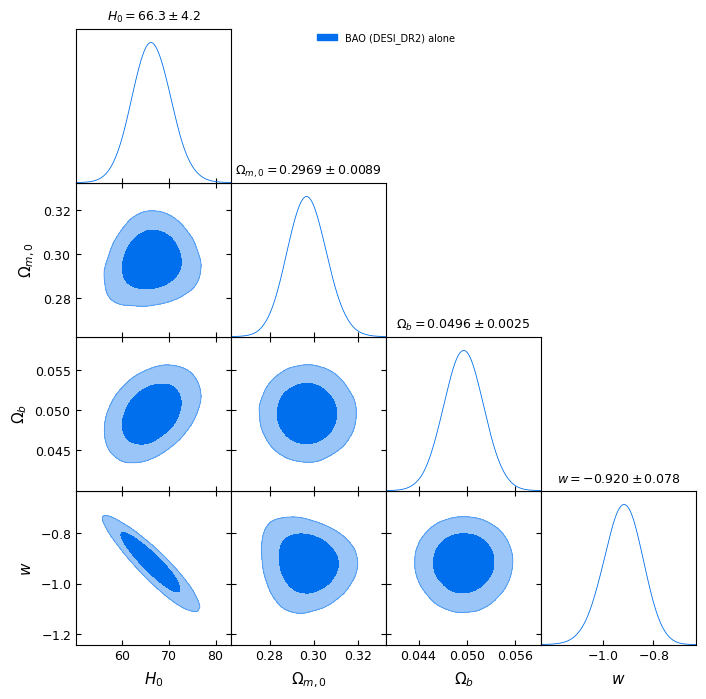

In [8]:
# =========================
# Corner plot using GetDist
# =========================

# Parameter names and LaTeX labels
param_names  = ["H0", "Omega_m0", "Omega_b", "w"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"\Omega_b", r"w"]


# Create GetDist samples object
samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

# Smoothing and binning settings
samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})


# Parameter ranges (optional)
# samples.setRanges({
#     "param p1": (p1_min, p1_max),
#     "param p2": (p2_min, p2_max),
#     "param p3": (p3_min, p3_max)
# })


# Initialize GetDist subplot plotter
g = plots.get_subplot_plotter()

# Plot styling settings
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3


# Triangle (corner) plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["BAO (DESI_DR2) alone"],
    #contour_colors=["#"],
    title_limit=1
)

# Save figure
plt.savefig("triangle_wCDM_bao.png", dpi=300, bbox_inches="tight")
plt.show()